Dataset shape: (9172, 31)

Missing values per column:
age                       0
sex                     307
on_thyroxine              0
query_on_thyroxine        0
on_antithyroid_meds       0
sick                      0
pregnant                  0
thyroid_surgery           0
I131_treatment            0
query_hypothyroid         0
query_hyperthyroid        0
lithium                   0
goitre                    0
tumor                     0
hypopituitary             0
psych                     0
TSH_measured              0
TSH                     842
T3_measured               0
T3                     2604
TT4_measured              0
TT4                     442
T4U_measured              0
T4U                     809
FTI_measured              0
FTI                     802
TBG_measured              0
TBG                    8823
referral_source           0
target                    0
patient_id                0
dtype: int64


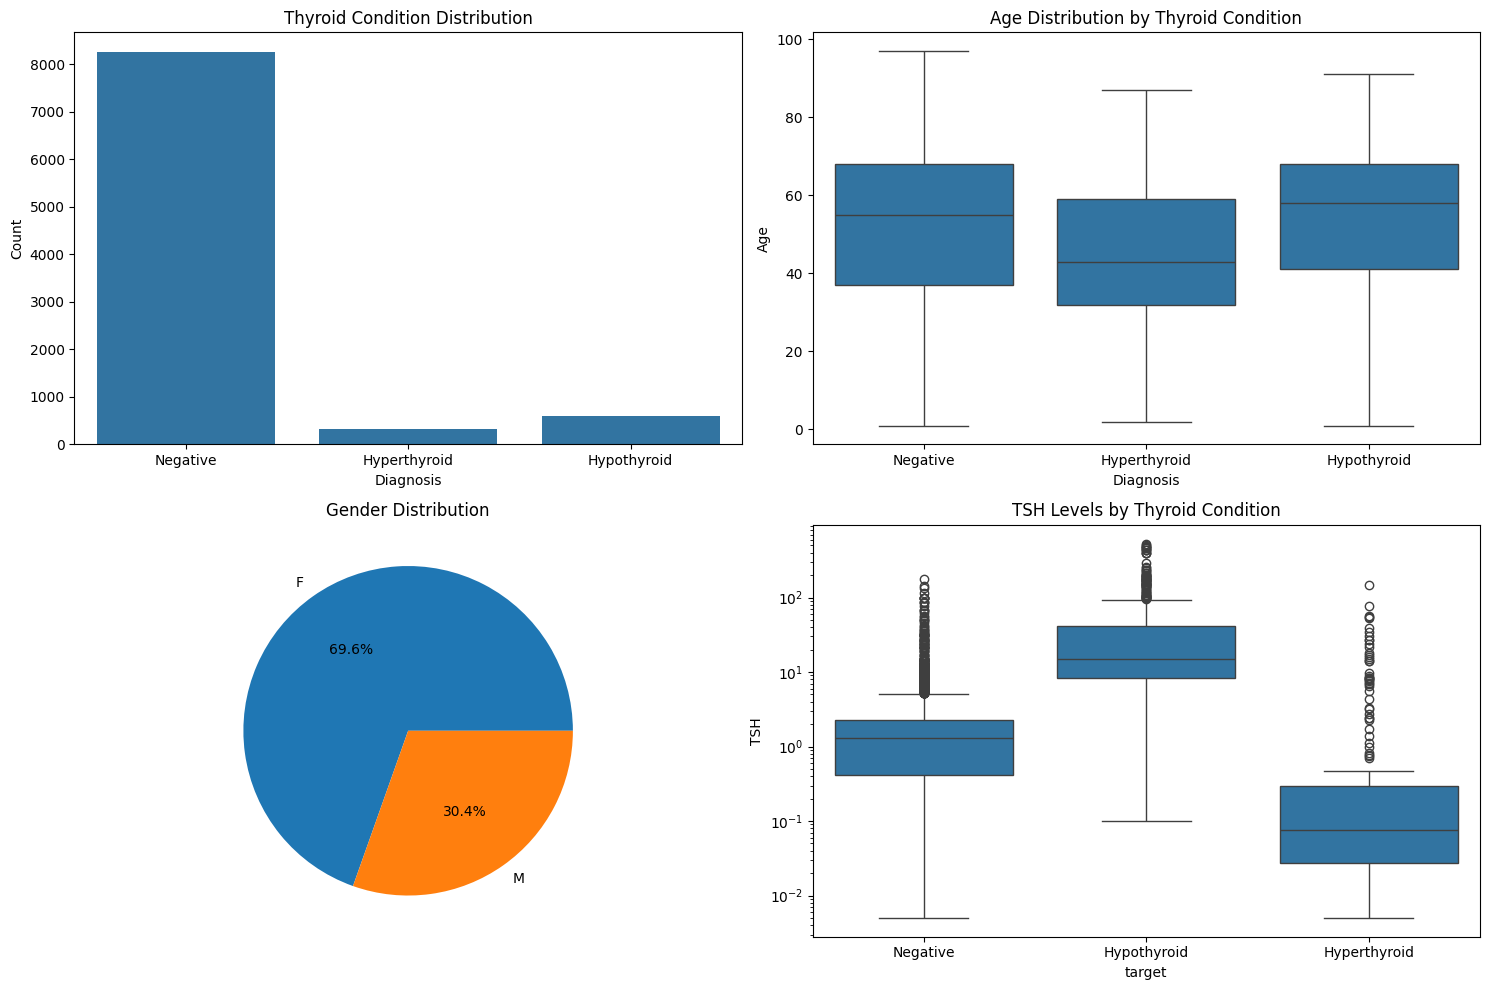


Random Forest Results:
Average CV Accuracy: 0.98

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.68      0.74        53
           1       0.93      0.99      0.96       103
           2       0.99      0.99      0.99      1678

    accuracy                           0.98      1834
   macro avg       0.91      0.89      0.90      1834
weighted avg       0.98      0.98      0.98      1834



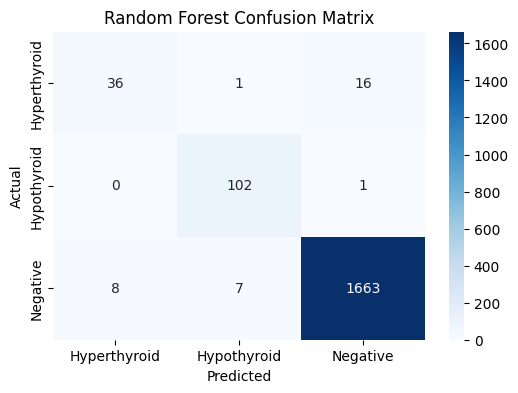


Logistic Regression Results:
Average CV Accuracy: 0.93

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.40      0.49        53
           1       0.76      0.46      0.57       103
           2       0.95      0.99      0.97      1678

    accuracy                           0.94      1834
   macro avg       0.79      0.61      0.68      1834
weighted avg       0.93      0.94      0.93      1834



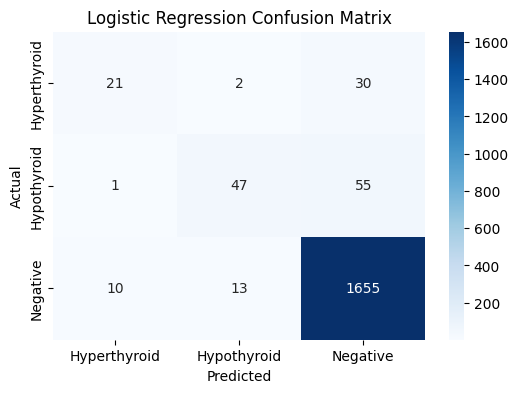


SVM Results:
Average CV Accuracy: 0.94

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.53      0.64        53
           1       0.82      0.41      0.55       103
           2       0.95      0.99      0.97      1678

    accuracy                           0.94      1834
   macro avg       0.86      0.64      0.72      1834
weighted avg       0.94      0.94      0.94      1834



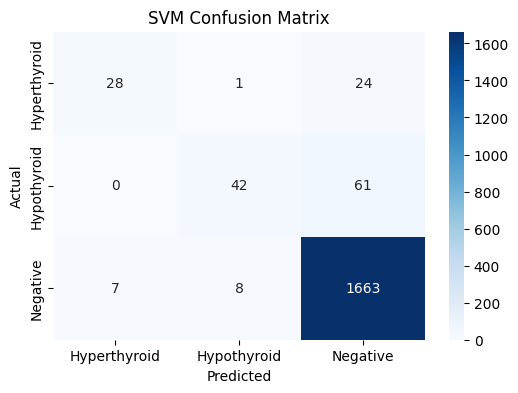


Gradient Boosting Results:
Average CV Accuracy: 0.98

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.75      0.77        53
           1       0.89      0.98      0.93       103
           2       0.99      0.99      0.99      1678

    accuracy                           0.98      1834
   macro avg       0.89      0.91      0.90      1834
weighted avg       0.98      0.98      0.98      1834



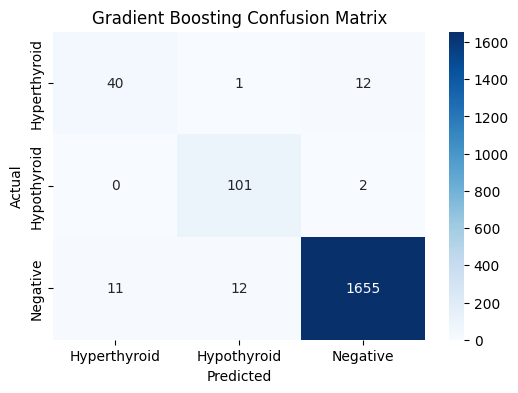


K-Nearest Neighbors Results:
Average CV Accuracy: 0.93

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.55      0.62        53
           1       0.81      0.38      0.52       103
           2       0.95      0.99      0.97      1678

    accuracy                           0.94      1834
   macro avg       0.83      0.64      0.70      1834
weighted avg       0.94      0.94      0.93      1834



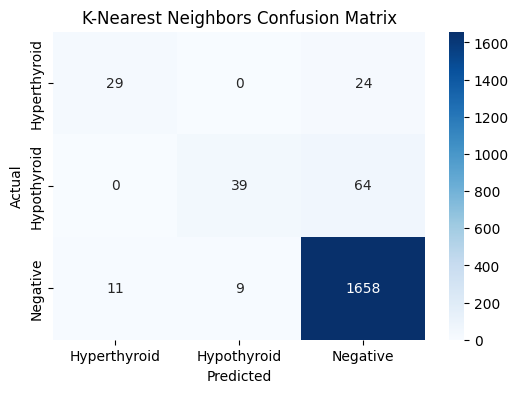

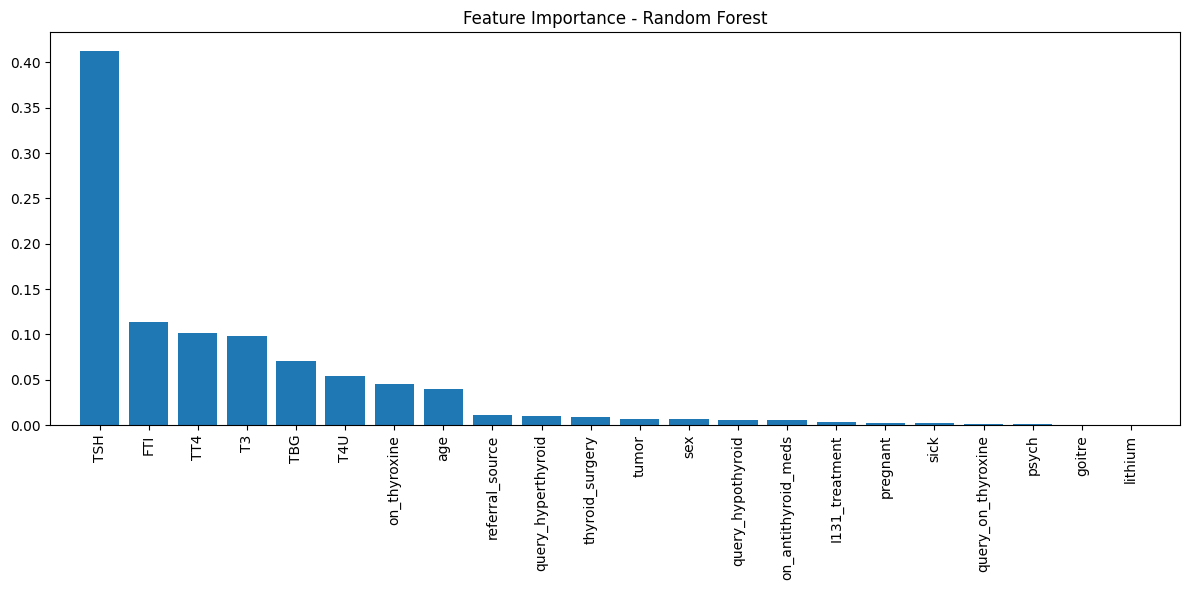

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv('/content/thyroidDF.csv')

# Data Exploration
print(f"Dataset shape: {df.shape}")
print("\nMissing values per column:")
print(df.isna().sum())

# Data Cleaning
# Drop unnecessary columns
cols_to_drop = ['TSH_measured', 'T3_measured', 'TT4_measured',
                'T4U_measured', 'FTI_measured', 'TBG_measured',
                'patient_id', 'hypopituitary']
df.drop(cols_to_drop, axis=1, inplace=True)

# Handle missing values
df['sex'] = df['sex'].fillna(df['sex'].mode()[0])  # Fill sex with mode
numeric_cols = ['TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']
df[numeric_cols] = df[numeric_cols].fillna(0)  # Fill numeric columns with 0

# Filter out unrealistic ages
df = df[df['age'] <= 100]

# Target variable processing
hyperthyroid_conditions = ['A', 'B', 'C', 'D', 'O', 'P', 'Q', 'S', 'T']
hypothyroid_conditions = ['E', 'F', 'G', 'H']

def categorize_target(value):
    if pd.isna(value):
        return None
    diagnoses = value.split('|')
    for diagnosis in diagnoses:
        if diagnosis in hyperthyroid_conditions:
            return 'Hyperthyroid'
    for diagnosis in diagnoses:
        if diagnosis in hypothyroid_conditions:
            return 'Hypothyroid'
    return 'Negative'

df['target'] = df['target'].apply(categorize_target)
df = df.dropna(subset=['target'])

# Data Visualization
plt.figure(figsize=(15, 10))

# 1. Target Class Distribution
plt.subplot(2, 2, 1)
sns.countplot(x='target', data=df)
plt.title('Thyroid Condition Distribution')
plt.xlabel('Diagnosis')
plt.ylabel('Count')

# 2. Age Distribution by Condition
plt.subplot(2, 2, 2)
sns.boxplot(x='target', y='age', data=df)
plt.title('Age Distribution by Thyroid Condition')
plt.xlabel('Diagnosis')
plt.ylabel('Age')

# 3. Gender Distribution
plt.subplot(2, 2, 3)
gender_counts = df['sex'].value_counts()
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%')
plt.title('Gender Distribution')

# 4. TSH Levels by Condition
plt.subplot(2, 2, 4)
sns.boxplot(x='target', y='TSH', data=df[df['TSH'] > 0])
plt.title('TSH Levels by Thyroid Condition')
plt.yscale('log')  # Using log scale due to wide TSH range

plt.tight_layout()
plt.show()

# Feature Engineering
# Encode categorical variables
df['sex'] = df['sex'].map({'F': 0, 'M': 1})
binary_cols = ['on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_meds',
               'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment',
               'query_hypothyroid', 'query_hyperthyroid', 'lithium',
               'goitre', 'tumor', 'psych']
for col in binary_cols:
    df[col] = df[col].map({'f': 0, 't': 1})

# Encode referral source
le = LabelEncoder()
df['referral_source'] = le.fit_transform(df['referral_source'])

# Encode target variable
df['target'] = le.fit_transform(df['target'])

# Prepare data for modeling
X = df.drop('target', axis=1)
y = df['target']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training and Evaluation
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)

    results[name] = {
        'accuracy': np.mean(cv_scores),
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

# Display results
for model_name, result in results.items():
    print(f"\n{model_name} Results:")
    print(f"Average CV Accuracy: {result['accuracy']:.2f}")
    print("\nClassification Report:")
    print(result['classification_report'])

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d',
                cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Feature Importance for Random Forest
rf = models["Random Forest"]
importances = rf.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importance - Random Forest")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()


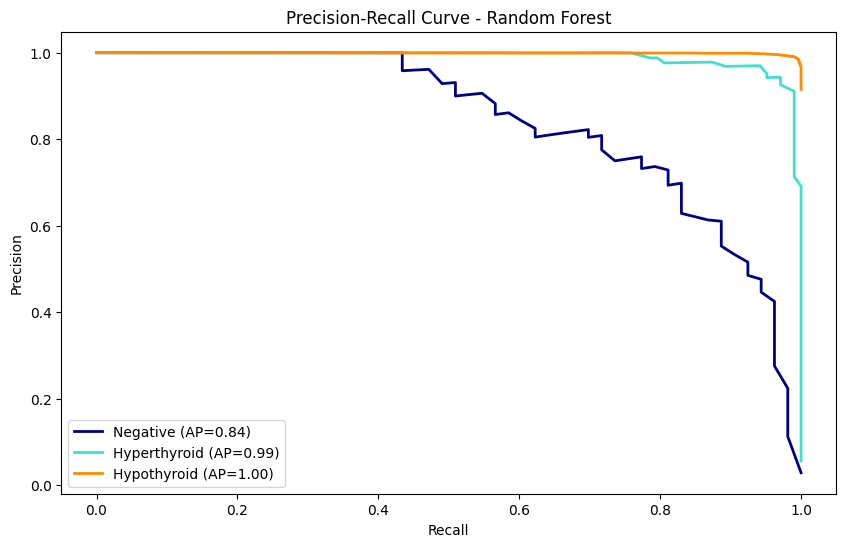

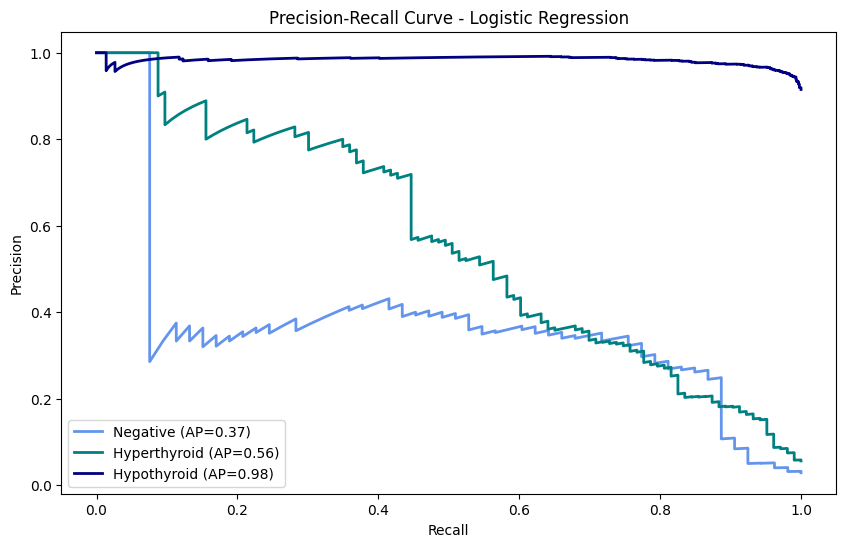

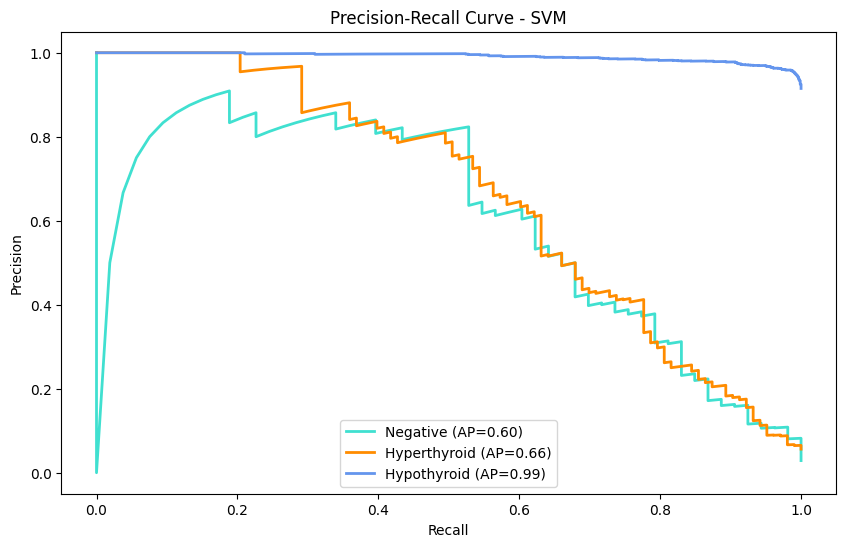

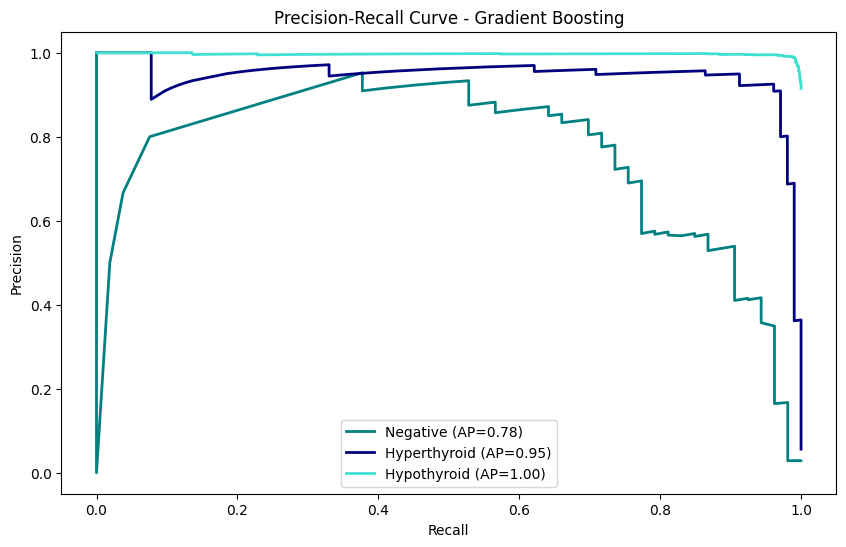

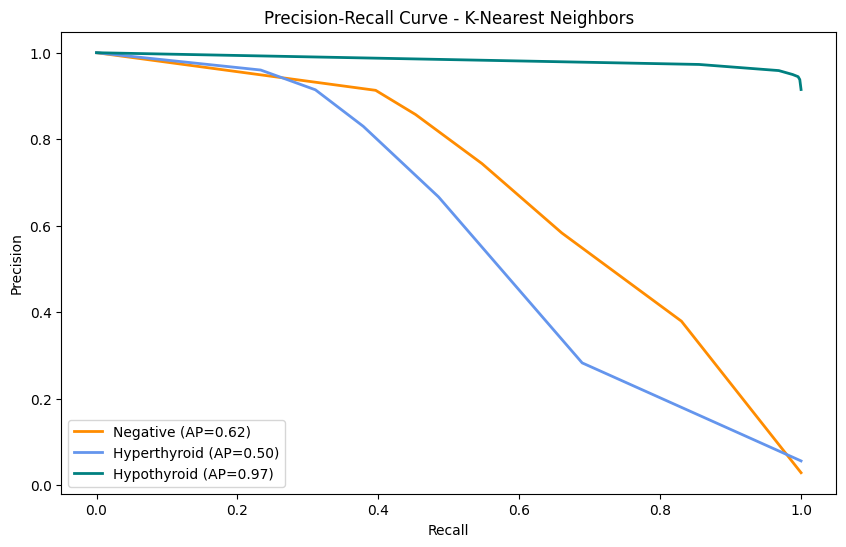

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from itertools import cycle

# Add extra classifiers
models["Gradient Boosting"] = GradientBoostingClassifier()
models["K-Nearest Neighbors"] = KNeighborsClassifier()

# Train new models and update results
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)

    results[name] = {
        'accuracy': np.mean(cv_scores),
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

# Binarize the target for multi-class precision-recall curves
y_test_bin = label_binarize(y_test, classes=np.unique(y))

# Define class labels
class_labels = {0: "Negative", 1: "Hyperthyroid", 2: "Hypothyroid"}

# Colors for different classes
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

for name, model in models.items():
    y_score = model.decision_function(X_test_scaled) if hasattr(model, "decision_function") else model.predict_proba(X_test_scaled)

    plt.figure(figsize=(10, 6))
    for i, color in zip(range(y_test_bin.shape[1]), colors):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        avg_precision = average_precision_score(y_test_bin[:, i], y_score[:, i])

        plt.plot(recall, precision, color=color, lw=2,
                 label=f'{class_labels[i]} (AP={avg_precision:.2f})')

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {name}")
    plt.legend(loc="best")
    plt.show()
